# **ETPoF** Homework 3
Annemarie Linnenbank & Tommie Verouden

*22 March 2024*

## Particle Tracking (25 points)
### 1) **Calibration** (3 pts)

Assume that the background noise is the same throughout the image, and the vertical line has an angle of 0° (which, on 
closer inspection, is the case).

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
import etpof

res_avg, res_std, offset = etpof.calibrate_cameras('PTV',
                                                   roi=[200, 250, 30, 670],
                                                   calib_dist=0.5, threshold=60,
                                                   file_prefix='Calibration_',
                                                   verbose=True, plot=False,
                                                   precision=7, units='m')

# TODO: Check average heigh offset compared beteen the two cameras
# TODO: Determine a way to combine cameras

100%|██████████| 2/2 [00:00<00:00, 168.04it/s]

==> Calibration_a.png:
The average resolution is 0.0048892 m/px,
with a standard deviation of 0.0000018 m/px (0.037556 %).
==> Calibration_b.png:
The average resolution is 0.0048895 m/px,
with a standard deviation of 0.0000017 m/px (0.034344 %).
Offset: -0.0000494 m


### 2) **Particle detection** (3 pts)

100%|██████████| 200/200 [00:00<00:00, 211.16it/s]


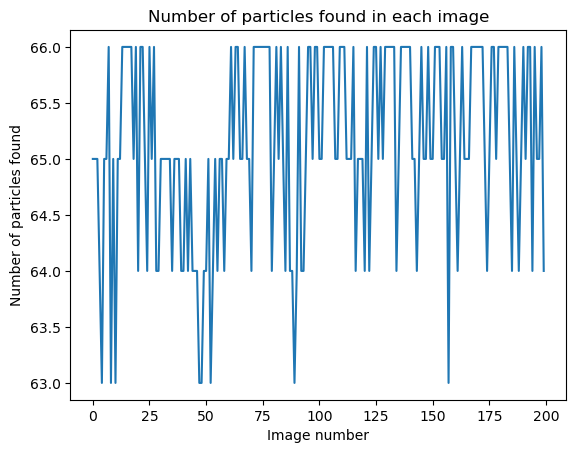

Found between 63 and 66 particles in each image, with a median of 65.0.


In [15]:
# For camera a
coords, intensities, coords_err, intensities_err, particles_found \
    = etpof.analyze_camera('PTV', 'a', res_avg[0], offset[0],
                           min_cnt_area=1, min_intensity=200, neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, plot=True)

# Todo: check frame number order

100%|██████████| 200/200 [00:00<00:00, 211.89it/s]


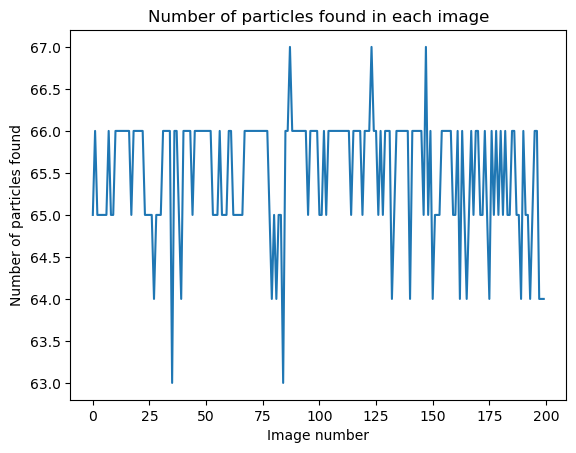

Found between 63 and 67 particles in each image, with a median of 66.0.


In [16]:
# For camera b
coords, intensities, coords_err, intensities_err, particles_found \
    = etpof.analyze_camera('PTV', 'b', res_avg[1], offset[1],
                           min_cnt_area=1, min_intensity=200, neighbor_dist=2.5,
                           box_margin=3, max_iter=5, verbose=True, plot=True)